# Quantum Approximate Multi-Objective Optimization (QMOO)

*Usage estimate: 5 seconds on ibm_torino (NOTE: This is an estimate only. Your runtime might vary.)*

#### Reference link: [Quantum Approximate Multi-Objective Optimization](https://www.nature.com/articles/s43588-025-00873-y)
Quantum approximate multi-objective optimization (QMOO) is a contender for near-term quantum advantage due to its potential to outperform classical approaches while only requiring modestly-sized quantum computations in conjunction with classical post-processing. QMOO determines an approximative solution to multi-objective optimization (MOO), i.e. an assignment $x\in X \subseteq \mathbb{R}^{n}$ is computed such that the output of a set of $m$ objective functions $f_{i}: X \mapsto \mathbb{R}$ is optimized, e.g.:

\begin{equation}
\max_{x\in X} f(x)=(f_{1}(x), ..., f_{m}(x))
\end{equation}

We find a popular example of MOO in our day-to-day life when traveling.
Traveling often exposes multiple objectives such as cost (e.g. fuel consumption, ticket prices), distance, duration, and ecological footprint that need to be optimized in combination.
Typically, it is not possible to optimize all objectives simultaneously, i.e. a change from $x\in X$ to $x' \in X$ may improve $f_i$ but may degrade $f_j$ at the same time (e.g. cheaper tickets often impose a longer travel time).
MOO therefore must compute a set of points $x \in P\subset X$ that define a Pareto front $F$

$$
F = \left\{ (f_1(x), \dots, f_m(x)) \;\middle|\;
\nexists x' \in X \;\text{such that}\;
\forall i\; f_i(x') \geq f_i(x) \;\wedge\;
\exists j\; f_j(x') > f_j(x)
\right\}
$$

The Pareto front contains the best solutions found by a MOO algorithm, i.e. there exists no $x' \in X$ such that the value of at least one objective function $f_{j}(x')$ is strictly better than $f_{j}(x)$ while all other objective functions $f_{i}(x')$ do not become worse than $f_{i}(x)$.

In the following example figure, a heuristic MOO procedure determined a set of variable assignments $x \in X$ with values $(f_{1}, f_{2})$ on the x- and y-axis, where both objective functions should be maximized.
The Pareto front in that output is depicted by points that are connected by a line.
Every point on the Pareto front is better along one dimension but worse on the second dimension than every other points on the Pareto front.
Every point not on the Pareto front is dominated by at least one point on the Pareto front, i.e. that point is worse in both dimensions.

In [ ]:
from qmoo_plot import plot_pareto
plot_pareto()

<div class="alert alert-block alert-success">

# Challenge instructions: QMOO 

### Your tasks

Implement code to compute the Pareto front for the multi-objective max-cut problem by employing the quantum approximate optimization algorithm (QAOA) and classical postprocessing (see https://arxiv.org/pdf/2503.22797) by following directions and filling in code below. Look for the `# PROMPT` marker inside the code boxes to find the places where code needs to be filled in. Where needed, there are specific `# BEGIN ANSWER` and `# END ANSWER` markers as well. 

Specifically, we will discuss:

1. The preparation of a suitable Ansatz circuit for multi-objective max-cut.
2. Sampling from the Ansatz circuit to explore points along the Pareto front.
3. A metric for quantifying the quality of a determined Pareto front. 
4. The classical postprocessing to determine the Pareto front from the Ansatz samples.

For didactic reasons, the explanations in this notebook will focus on the $m=2$ dimensional optimization, i.e. the maximization of max-cut values on two graphs, while the second part is on $m=3$ objectives.

## Grading system (100 points):

### Ex.1: Solving the Max-cut of MOO and explore points along the Pareto Front (10 points)
### Ex.2: Determining the Pareto Front from the ansatz samples (5 points)
### Ex.3: Creating the isa circuit for Max-cut on Static 3-Regular 80-Node Graphs (10 points)
### Ex.4: Solving the Max-cut on Static 3-Regular 80-Node Graphs and post-process the samples into the Hypervolume / Pareto front (75 points) 
<div>


## Python imports

We assume that we start from a Python environment that has been initialized by following the instructions.

In [1]:
from qmoo_files import load_problem
from qmoo_plot import plot_graphs, plot_pareto_hv

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerOptions, SamplerV2
from qiskit.circuit import ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy
from qiskit.transpiler import CouplingMap
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit_aer.primitives import SamplerV2 as SamplerAerV2

from qiskit_addon_opt_mapper.applications import Maxcut
from qiskit_addon_opt_mapper.translators import to_ising
from qopt_best_practices.transpilation import UnrollBoxes
from qopt_best_practices.transpilation.generate_preset_qaoa_pass_manager import generate_preset_qaoa_pass_manager

from matplotlib import pyplot as plt
from moocore import hypervolume, filter_dominated


import networkx as nx
import numpy as np

In [7]:
service = QiskitRuntimeService(name="r2p-2025")

backend = service.least_busy(simulator=False, operational=True)

print(f"Using backend {backend.name}")

Using backend ibm_boston


Import the grader functions and submit the team name to which your points should be assigned:

In [8]:
from grader_ch1 import challenge1, grader_ch1_ex1, grader_ch1_ex2, grader_ch1_ex3, grader_ch1_ex4
# PROMPT Define your team name
YOUR_TEAM_NAME = "r2p_converters"
challenge1.submit_name(YOUR_TEAM_NAME)

Grading your answer. Please wait...
Team name submitted.


## Multi-objective optimization by using QAOA

In this challenge, we will develop a quantum approach to solve MOO problems by drawing inspiration from the weighted sum method (WSM), which is a classical approach to solving MOO problems.
In the WSM, a single objective function 
\begin{equation}
f_{c}(x)= \sum_{i=1}^{m} c_{i} f_{i}(x)
\end{equation}
is generated for the MOO $\max_{x\in X} f_{i}(x)$.
The optimization of $f_{c}(x)$, i.e. finding a suitable assignment to $x$ such that $f_{c}(x)$ is optimized, will then be determined by a regular, single-objective optimization procedure.
Given a suitable discretization of the the weight vectors $c\in [0, 1]^m$, the WSM approach allows us to determine the Pareto front of a given MOO problem defined by objective functions $f_i$.
As an alternative to discretizing the weight vectors $c$, a set of random the weight vectors $c$ with $\sum_{i}c_{i}=1$ each can be chosen to define $f_c(x)$.

### Hypervolume - A metric for quantifying the quality of a Pareto front
The hypervolume is a widely used metric for quantifying the quality of a Pareto front (blue dots).
For two objective functions, the _hypervolume_ is defined as the area beneath the determined Pareto front with respect to a reference point, as shown in green in the following figure (for more than two objective functions, this area becomes a volume).
In this case, the reference points is simply $(0, 0)$. In the more general case, the reference point is typically determined to be the lower bound of the individual objective functions, e.g. $(\min f_{1}(x), \min f_{2}(x)).$
A lower bound can be obtained efficiently for many optimization via LP relaxation. 

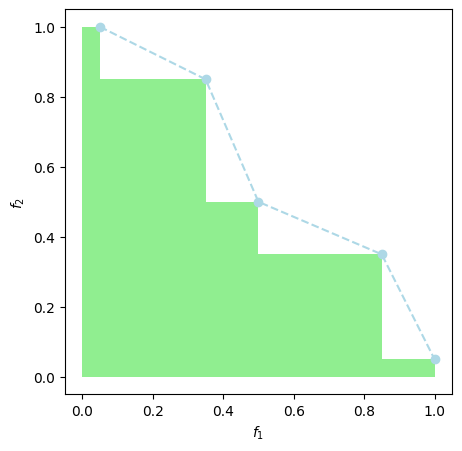

In [9]:
plot_pareto_hv(hv=True, second=False)

When comparing two Pareto fronts $P_{1}, P_{2}$ for the same MOO problem, the solutions in the Pareto front with the larger hypervolume ($P_1$) dominate the solutions in the Pareto front with the smaller hypervolume ($P_2$).

\begin{equation}
\forall y \in P_2 \;\forall i \in \{1, \dots, m\} \;\exists x \in P_1 \;\text{such that}\; f_i(x) \geq f_i(y) \;\wedge\; \exists j \in \{1, \dots, m\} \; f_j(x) > f_j(y),

\end{equation}
i.e. for all points in Pareto front, $P_2$, there is at least one point in $P_1$ that has one strictly larger objective function value, while the other objective function values are at least as large as for the point in $P_2$.
Furthermore, a larger hypervolume implies a larger diversity in solutions and a smaller distance of solutions to the true Pareto front.
See the following plot with a green and orange hypervolume and corresponding Pareto fronts depicted by an orange cross or a blue dot. The Pareto front depicted by orange crosses is dominated by the Pareto front depicted by dots.

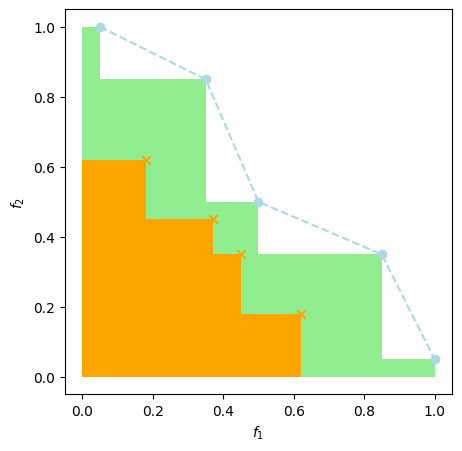

In [10]:
plot_pareto_hv(hv=True, second=True)

## 0. Generate a random MOO max-cut problem
We start by generating a $m=3$ MOO max-cut problem on a graph with $42$ nodes:

In [11]:
# Note: we show how to determine `qaoa_params`, `upper_bounds`, `lower_bounds` in subsequent cells of the notebook 

moo_graphs, qaoa_params, upper_bound, lower_bound = load_problem("./instances/soa_42q/")
n_obj = len(moo_graphs)

loading ./instances/soa_42q/problem_graph_*.json


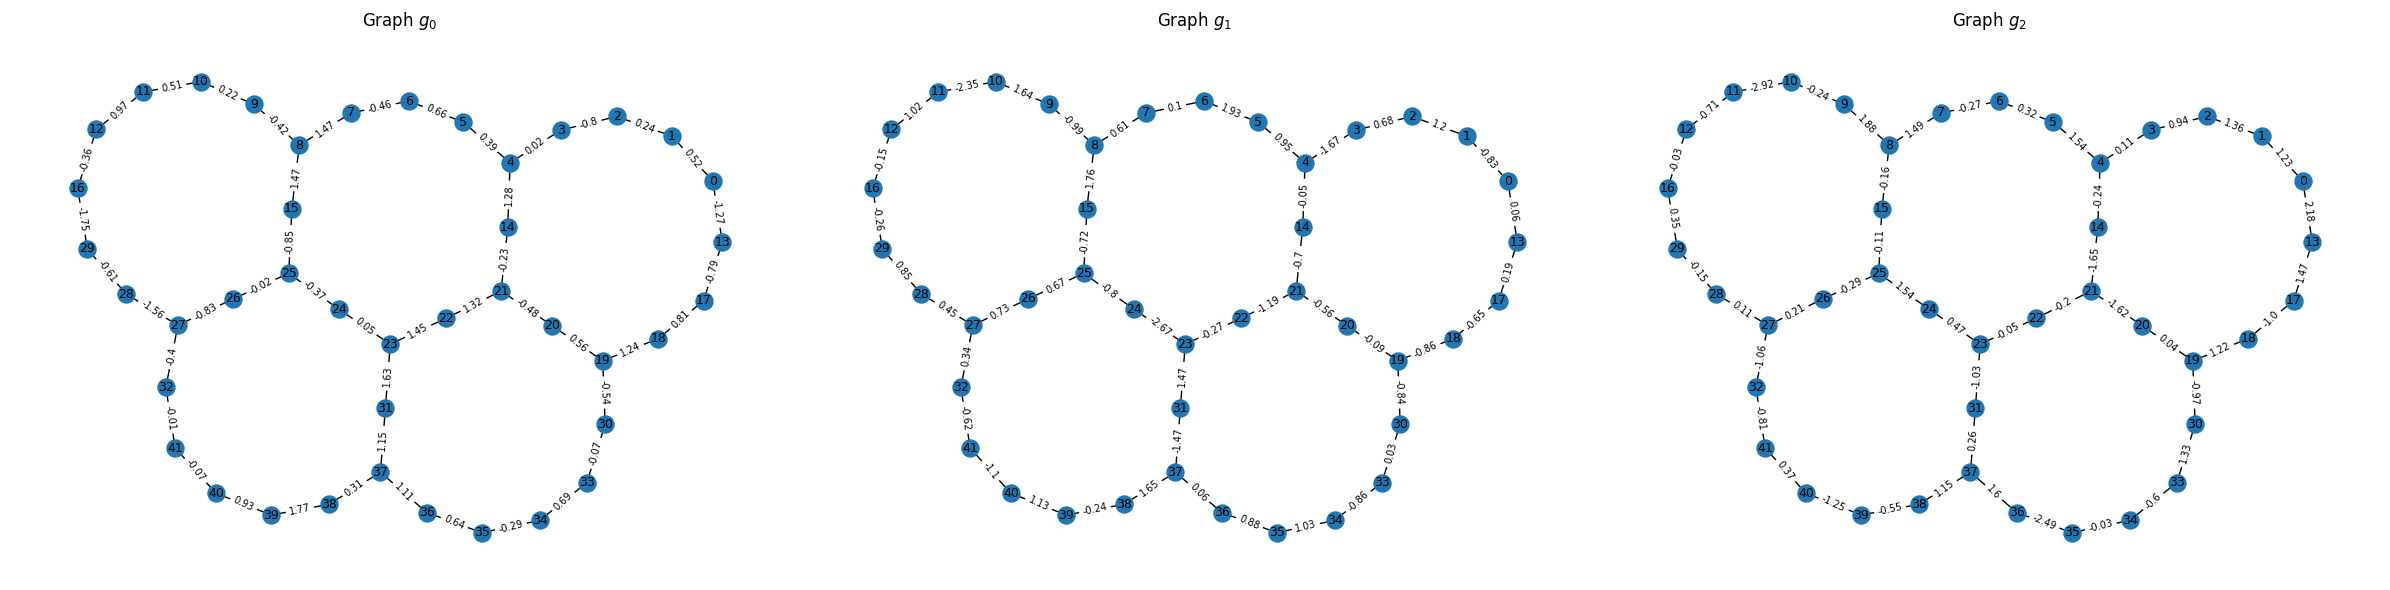

In [12]:
# plot the target max-cut graphs
plot_graphs(moo_graphs)

The $n$-node Max-Cut MOO problem consists of finding an assignment $x\in \{0, 1\}^{n}$ such that cuts induced by $x$ in the graphs shown above are maximal, i.e. the sum of weights between edges of nodes with $x_{i}=1$ to nodes with $x_{j}=0$ is maximized for graphs $G=\{g_{0}, g_{1}, g_{2}\}$.

### 1. Generate a QAOA ansatz circuit for the max-cut MOO

The following is a brief introduction to QAOA, read the paper [A Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028) for theory and try the [Quantum approximate optimization algorithm](https://quantum.cloud.ibm.com/docs/tutorials/quantum-approximate-optimization-algorithm) tutorial, as well as the [Utility-scale QAOA](https://quantum.cloud.ibm.com/learning/courses/quantum-computing-in-practice/utility-scale-qaoa) course for practical insights.
In QAOA, a quadratic unconstrained binary optimization problem (QUBO) over $n$ variables and with cost matrix $Q$ is solved by finding the ground state of the Ising Hamiltonian $H_C$:

\begin{equation}
H_{C} = -\sum_{i < j} J_{ij} \sigma^{z}_{i} \sigma^{z}_{j} - \sum_i h_i \sigma^{z}_{i},
\end{equation}

where $J_{ij}$ and $h_{i}$ are obtained from the cost matrix $Q$.

This ground state is determined by preparing and measuring

\begin{equation}
|\psi(\beta, \gamma)\rangle = \prod_{k=1}^{p} e^{-i\beta_k H_X} e^{-i\gamma_k H_C} |+\rangle,
\end{equation}

where $H_x= -\sum_{i} \sigma^{x}_{i}$ is the mixing Hamiltonian, $\beta, \gamma$ are variational parameters and $p$ is the number of QAOA layers. Determining the max-cut on a graph with weights $w_{uv}$ on an edge $e=\{u, v\}$ between nodes $u, v$ requires setting
\begin{equation}
H_{C} = \sum_{u,v} (1 - Z_{u}Z_{v}),
\end{equation}
up to a constant energy offset $\frac{1}{2}\sum_{u,v}w_{uv}$.
Each term of above sum results in a $\texttt{RZZ}(w_{u, v} \gamma)$ gate on the qubits representing nodes $u, v$. The mixing Hamiltonian can be represented by individual $\texttt{RX}(2\beta)$ single-qubit gates on each qubit.

Solving a sum of max-cut problems over individual graphs $g_{i}\in G$ as required by the WSM approach

\begin{equation}
\max_{x\in X} \sum_{i=1}^{m} c_{i} f_{i}(x),
\end{equation}

can be represented by solving one max-cut problem on a combined graph $g$ that includes all edges of graphs $g_{i} \in G$, where the edge weight $w_{g,e}$ of edge $e$ in graph $g$ is determined by

\begin{equation}
w_{g, e} = \sum_{i} c_{i} \cdot w_{g_{i}, e}
\end{equation}

We can thus generate a suitable parameterized ansatz circuit for $p=2$ layers with a multi-objective-weighting vector $c$ as follows.
Note that the best number of QAOA layers $p$ depends on the error rate of the target QPU, the optimization problems considered in MOO, and problem instances considered (i.e. size and structure of input graphs for max-cut). 

In [13]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

p_layers = 2
maxcuts = [Maxcut(g) for g in moo_graphs]
cost_ops = [to_ising(mc.to_optimization_problem())[0].simplify() for mc in maxcuts]
c_vec = ParameterVector("c", len(cost_ops))
sum_cost_op = sum(c_vec[idx] * hc for idx, hc in enumerate(cost_ops)).simplify()

# Note that we created an ansatz circuit where the individual QAOA cost and QAOA mixer layers are annotated for improved transpilation
qc = annotated_qaoa_ansatz(sum_cost_op, reps=p_layers)
qc.measure_all(inplace=True)
qc.draw(idle_wires=False,fold=-1)


┌─────── ┌───┐ ───────┐ ┌───────                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ───────┐ ┌─────── ┌────────────┐ ───────┐ ┌───────                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Next, we need to train the QAOA ansatz circuit, i.e. determine suitable parameters $\beta, \gamma$ while fixing $c$ to a unit value. 
It has been observed that the QAOA parameters $\beta, \gamma$ can be used for a large set of graphs once they have been optimized for a specific graph instance.
We therefore expect one set of QAOA parameters $\beta, \gamma$ to work well on any vector $c$ once optimized subject to the unit vector, i.e. in this case $c=(1/3, 1/3, 1/3)$.
We use an approximative quantum simulator and an iterative optimizer such as COBYLA to determine the parameters. Other options for determining parameters may include extrapolations via parameter transfer rules or static parameter schedules such as linear-ramps, for example.

> **Note:** This step can take a while for a large number of qubits and QAOA layers!

In [14]:
load_params_file = True

if load_params_file:
    # load low-effort QAOA parameters from file, see `else` branch for how to get advanced QAOA parameters
    params = qaoa_params[str(p_layers)]
    ansatz_qc = qc.assign_parameters(params)
else:
    # Train QAOA using the QAOA training pipeline https://github.com/qiskit-community/qaoa_training_pipeline
    from qaoa_training_pipeline.training import ScipyTrainer
    from qaoa_training_pipeline.evaluation import MPSEvaluator, StatevectorEvaluator
    
    trainer = ScipyTrainer(MPSEvaluator(bond_dim_circuit=20), minimize_args={"options": {"maxiter": 500}})
    # Use an exact simulator for small-scale quantum computations
    # trainer = ScipyTrainer(StatevectorEvaluator())

    # parameter initialization according to https://arxiv.org/pdf/2101.05742
    dt = 0.75
    grid = np.arange(1, p_layers + 1) - 0.5
    init_params = np.concatenate((1 - grid * dt / p_layers, grid * dt / p_layers))

    # `train` minimizes the cost operator, note the -1 prefactor
    training_result = trainer.train(sum(-1/len(cost_ops) * hc for hc in cost_ops).simplify(), init_params)
    params = training_result['optimized_params']
    betas = {f"β[{i}]": param for i, param in enumerate(params[:len(params)//2])}
    gammas = {f"γ[{i}]": param for i, param in enumerate(params[len(params)//2:])}
    params = betas | gammas
    ansatz_qc = qc.assign_parameters(params)
print("QAOA parameters", params)

QAOA parameters {'β[0]': 3.8473156487317204, 'β[1]': 3.679937252479205, 'γ[0]': -0.99362765274028, 'γ[1]': 0.3555146452475003}



### 2. Optimize the ansatz circuit for execution on the QPU

Before we can execute the ansatz circuit, we need to transpile the quantum circuit for the specified the target quantum computer. This can take 1~2 minutes.


In [15]:
# we first need to transpile the circuit before running it on a real device!
# see https://github.com/qiskit-community/qopt-best-practices/tree/main/how_tos for further transpilation improvements   
# swap strategy and coloring for native heavy-hex graphs
edge_coloring = nx.greedy_color(
    nx.line_graph(moo_graphs[0]), strategy="saturation_largest_first"
)
edge_coloring.update({(k[1], k[0]): v for k, v in edge_coloring.items()})

num_colors = len(set(edge_coloring.values()))

# Make an empty swap strategy as we have a hardware-native graph here
cmap = CouplingMap(moo_graphs[0].edges())
cmap.make_symmetric()

swap_strategy = SwapStrategy(cmap, ())  # no SWAPs needed

staged_pm = generate_preset_qaoa_pass_manager(backend, swap_strategy, initial_layout=None, edge_coloring=edge_coloring)
# 4. Run the Qiskit transpilation with the above defined custom passes
isa_qc = staged_pm.run(ansatz_qc)
naive_isa_qc = generate_preset_pass_manager(backend).run(UnrollBoxes()(ansatz_qc))


print("Two-qubit gate depth", isa_qc.depth(lambda x: len(x.qubits)>1))
print("Number of two-qubit gates", isa_qc.num_nonlocal_gates())
print("Two-qubit gate depth - Naive", naive_isa_qc.depth(lambda x: len(x.qubits)>1))
print("Number of two-qubit gates - Naive", naive_isa_qc.num_nonlocal_gates())

Two-qubit gate depth 13
Number of two-qubit gates 184
Two-qubit gate depth - Naive 43
Number of two-qubit gates - Naive 184


### 3. Sample from the ansatz circuit to explore points along the Pareto front [10pts]

As we now have the optimized ansatz circuit, we only need to sample from it with a set of objective-weighting vectors $c$ and determine the set of feasible samples from it. We use the Qiskit Aer state vector simulator for now. Running on a real QPU will only require a change in `SamplerV2`.
The next cell can run for up to ~5 minutes as we determine loose upper and lower bounds for the individual max-cut problems by means of solving a linear program.

In [16]:
# how many samples should be drawn
n_samples = 100
# how many shots per sample
shots = 100

The WSM approach to MOO allows us to explore the Pareto front best if the random weight vectors are distributed uniformly on a d-dimensional simplex.
Drawing from the normal or uniform distribution directly with a subsequent rescaling may lead to clustering or a concentration around the center of the distribution.
Therefore, the next task is to develop a function `gen_cvecs` that generates `n_samples`-many `n_obj`-dimensional points.

In [17]:
# PROMPT: draw random n_samples for the n_obj-dimensional c vectors
# note that drawing from the uniform or normal distribution (with subsequent normalization)
# to get positive weights that sum up to one leads to a concentration of values around the center
def gen_cvecs(n_samples, n_obj=3):
    c_vecs = np.zeros(shape=(n_samples, n_obj+1))
    # BEGIN ANSWER, generate n_samples random n_obj-dimensional points
    # Using the Dirichlet distribution with alpha=1 ensures a uniform distribution 
    # over the simplex, avoiding the central concentration effect.
    c_vecs = np.random.dirichlet(np.ones(n_obj), size=n_samples)
    # END ANSWER 
    return c_vecs

c_vecs = gen_cvecs(n_samples=n_samples, n_obj=n_obj)

In [18]:
grader_ch1_ex1(gen_cvecs)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 10.0.


In [19]:

# set error mitigation options for the sampler
options = SamplerOptions()
options.max_execution_time = 600
sampler = SamplerV2(mode=backend, options=options)
    
job = sampler.run([(isa_qc, c_vecs)], shots=shots)
print("Submitted job to", backend.name, "with id", job.job_id(), "and the following options")
sampler.options

Submitted job to ibm_boston with id d5fbp4cpe0pc73ajqrk0 and the following options


max_execution_time,600
default_shots,Unset
experimental,Unset
▸environment,EnvironmentOptions
log_level,'WARNING'
callback,None
job_tags,None
private,False
▸simulator,SimulatorOptions
noise_model,Unset
seed_simulator,Unset


Retrieve results from the QPU when the job has been completed.

In [20]:
sample_res = job.result()
sample_counts = [sample_res[0].data.meas.get_counts(s) for s in range(n_samples)] 

### Step 4. Classical post-processing to determine the Pareto Front from the ansatz Samples [5pts]

We can evaluate the QAOA-based WSM approach by determining the hypervolume induced by the samples generated from the QAOA ansatz circuit.
Note that we may need to process a large amount of data efficiently.
For instance, the state of the art as given by the reference in [Quantum approximate multi-objective optimization](https://www.nature.com/articles/s43588-025-00873-y) processes 5000 samples of 5000 shots each, yielding 25 million MOO solutions for a 42-qubit circuit representing three max-cut objectives.
An inefficient post-processing would take on the order of 40 minutes to complete.
However, the optimized post-processing implemented in the next three cells takes roughly 4 minutes for the 25 million MOO samples.

We first need to transform the measured bitstrings into the right format, i.e. transform sets of strings representing the measurement results into a compact array of Boolean values.

In [21]:
# Here, we copy the string to our new location, interpret it as ASCII characters where a '0' has the value 48 and a '1' has the value 49, and get to an array of Boolean values by subtracting 48 it from it.
bitstring_length = len(next(iter(sample_counts[0].keys())))
x = np.fromiter((np.frombuffer(k.encode("ascii"), dtype="u1") - 48 for i in range(n_samples) for k in sample_counts[i].keys()), dtype=np.dtype((np.uint8, bitstring_length)))

Next we need to determine the max-cut value of each graph given a variable assignment as defined by `x`.

In [22]:
# get the adjacency matrix of each graph
adj_m = [nx.adjacency_matrix(moo_graphs[i]).toarray() for i in range(n_obj)]
# compute the max-cut value for each input graph, note that `x` is a Boolean array so `1-x` is its complement, thus `x`adj_m`(1-x)` selects exactly the edges (and their weights) across the cut
fis = np.stack([np.sum((x @ adj_m[i]) * (1 - x), axis=1) for i in range(n_obj)], axis=1)
# process each sample only once 
fis = np.unique(fis, axis=0)

Finally, we determine the hypervolumes of successively larger sets of samples for analysing the performance of the QAOA-approach to MOO.

In [23]:
# set the reference point from which to compute the Hypervolume
hv_ref_point = np.array(lower_bound)
print("Reference Point", hv_ref_point)

num_batches = 1000 if len(fis) > 10000 else len(fis)//10
batch_size = int(len(fis)/num_batches)
hvs = []
for i in range(batch_size, len(fis), batch_size):
    # use an external library to determine the pareto front and its Hypervolume
    hv = hypervolume(fis[:i], ref=hv_ref_point, maximise=True)
    hvs.append(hv)

# included all samples in the last Hypervolume computation
hvs.append(hypervolume(fis, ref=hv_ref_point, maximise=True))


# the Pareto front is determined during the hypervolume computation, we assign it explictly here
pareto_front = filter_dominated(fis)
print("Hypervolume induced by all samples", hvs[-1])
print("The Pareto front is defined by", len(pareto_front), "points.")
print("A point of the Pareto front is", pareto_front[0])

Reference Point [-13. -20. -19.]
Hypervolume induced by all samples 25774.579279898157
The Pareto front is defined by 57 points.
A point of the Pareto front is [-6.26213671  2.43222219  6.96686771]


In [24]:
grader_ch1_ex2(max(hvs))

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 5.0.


Congratulations on finishing the first part of this challenge on replicating the approach of the state of the art!
Note that the recently published paper achieved a hypervolume of ~43000 but required 25 Mio samples. Enjoy the rest of the challenge!

Now we can really see how the hypervolume increases as the QPU computes more and more solutions (samples) of the multi-objective max-cut problem defined in the beginning of this notebook.

Text(0, 0.5, 'Hypervolume')

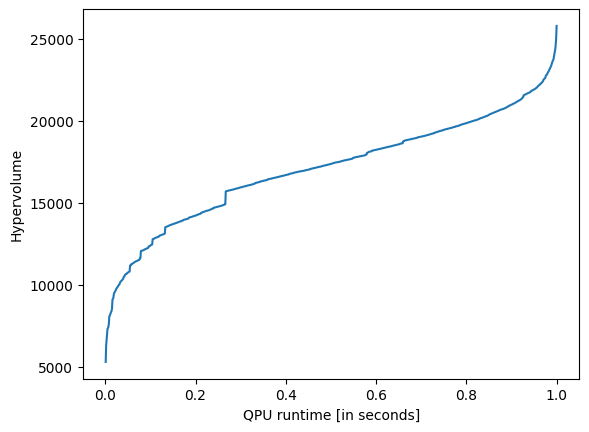

In [25]:
# we assume a 10kHz sampling rate
qpu_freq = 10000
time_per_sample = batch_size/qpu_freq
max_hvs = [hvs[i] for i in range(len(hvs))]
seconds = [time_per_sample*(i+1) for i in range(len(hvs))]

plt.plot(seconds, max_hvs)
plt.xlabel("QPU runtime [in seconds]")
plt.ylabel("Hypervolume")

The following figure from the [state-of-the-art paper](https://www.nature.com/articles/s43588-025-00873-y) shows the MOO solution quality on the same set of graphs as processed in this challenge.
The y-axis depicts a measure of hypervolume quality with the orange dotted line showing the maximum hypervolume and the x-axis depicts the QPU runtime in seconds for QAOA approaches on a QPU (ibm_fez) or on a simulator (MPS sim.) and the CPU runtime of three classical approaches called $\epsilon$-CM, DCM, and DPA-a.
As shown in the figure, the presented QAOA approach to MOO is competitive to classical approaches in terms of solution quality and runtime when only the QPU runtime is considered.

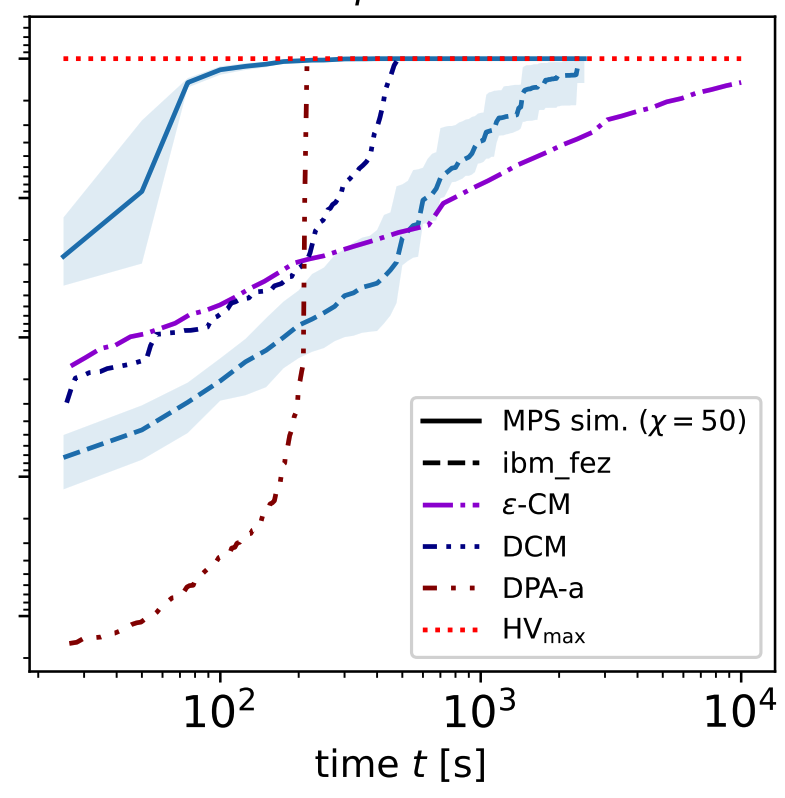

In [26]:
from IPython.display import Image, display
display(Image(filename='figures/paper_comarison.png', width=500))

## Challenge

The challenge concludes with a grader cell with which participants can submit their solution to our grading system.
The grading consists of an automated sanity check and a following manual check of the top submissions.
This challenge awards points corresponding to the hypervolume induced by the submitted samples.

#### Hints
We expect the best submissions to this challenge to involve innovation in:
- QAOA ansatz: There could be better ways to sample solutions from the weighted sum of objective functions. You can vary the number of QAOA layers (`p_layers` in above code) to tradeoff an increase in noise with potentially sampling closer to the optimum.
- QAOA parameters: The QAOA parameters on file are determined by a coarse simulation. Fine-tuning the parameters may allow for higher-quality samples and thus to a faster time to result or a better hypervolume. One way of potentially determining better parameters is described in the [Optimization with light-cones](https://github.com/qiskit-community/qaoa_training_pipeline/blob/main/how_tos/light_cone_optimization.ipynb) how-to notebook, but there also other approaches mentioned in this repository.
- Transpilation: The structure of the graphs in this challenge is regular and may therefore yield improvements via structure-specific transpilation methods. One example of such methods is given in the [How to apply optimal QAOA transpilation with a StagedPassManager](https://github.com/qiskit-community/qopt-best-practices/blob/main/how_tos/how_to_apply_optimal_qaoa_transpilation.ipynb) notebook.  This transpilation method is also used for the 42-qubit example above, but the swapping strategy needs to be adapted to the 3-regular structure of the input graph.
- Quantum error mitigation: Running a quantum circuit on a QPU will inevitebly incur errors. The QMOO approach presented in this notebook is natively resilient against noise, but improving the quality of the samples may allow you to find a solution more efficiently or effectively. Local searches similar to configuration recovery methods in sampling-based quantum diaganlization (SQD) or other post-selection approaches may be beneficial. 
- Post-processing: There may be more efficient ways to explore the Pareto front of the graph problems introduced in this challenge.
Make sure you are not assuming any information about the solution to the MOO problem to determine a suitable error mitigation or post-processing technique!

We are curious about novelty in any other aspect and look forward to your submission!

### Challenge: Max-cut on static 3-regular 80-node graphs [75pts]

loading ./instances/3_regular_static_80q/problem_graph_*.json


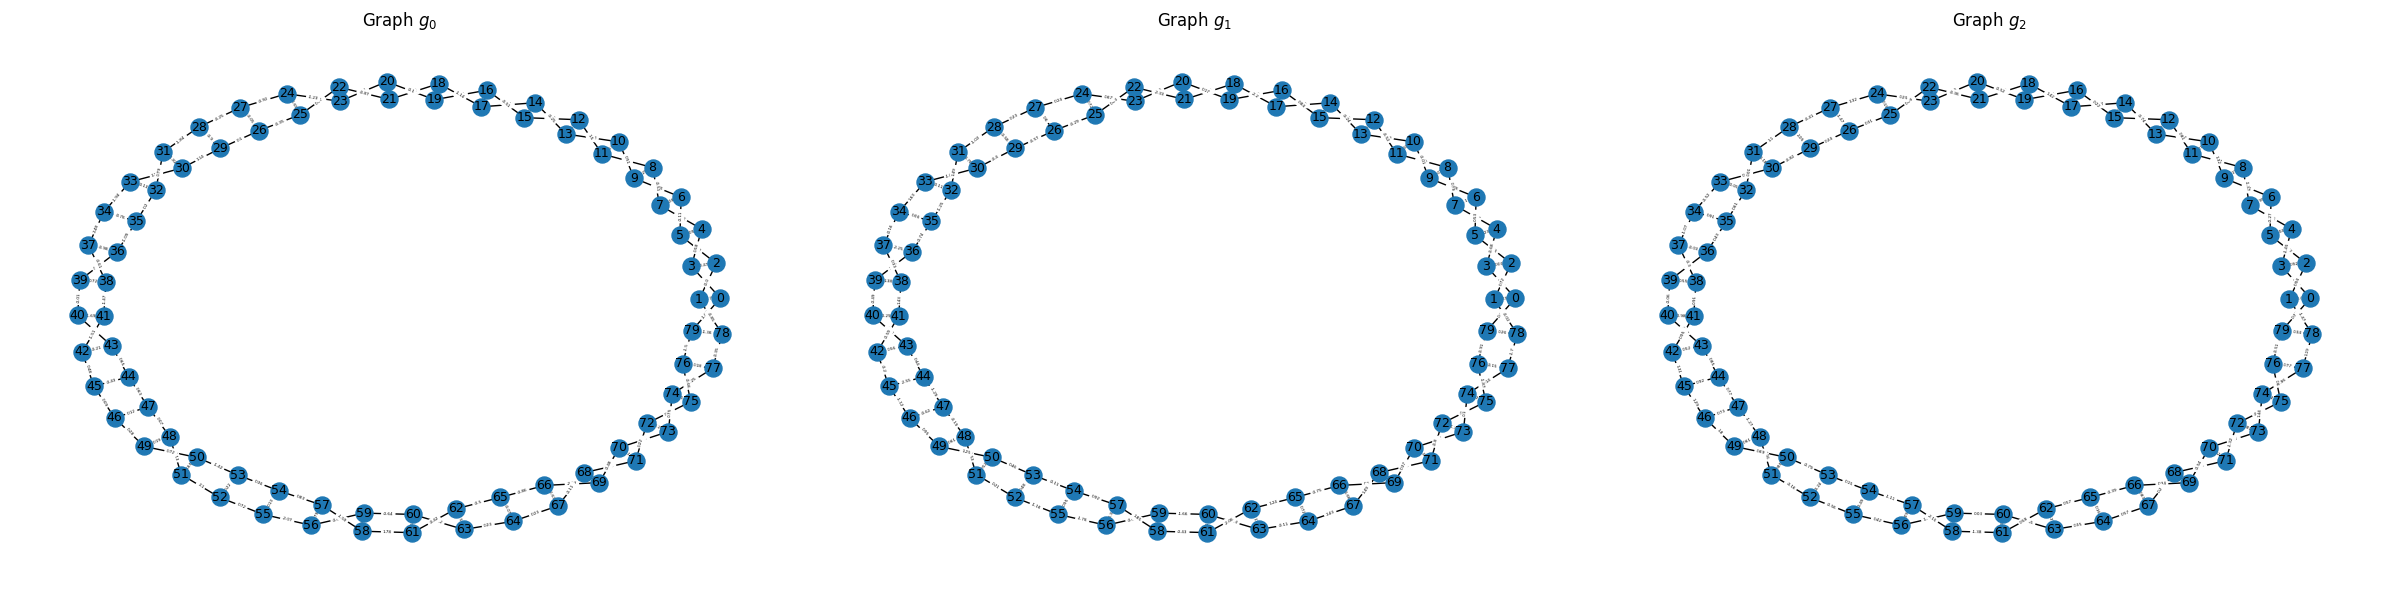

In [27]:
# Note that the QAOA parameters loaded from file here are determined by a coarse simulation and can likely be improved
# you can find 12-node graphs at "./instances/3_regular_static_12q/" and "./instances/circle_12q/" for prototyping purposes
moo_graphs, qaoa_params, upper_bounds, lower_bounds = load_problem("./instances/3_regular_static_80q/")

plot_graphs(moo_graphs)

In [66]:
# PROMPT
# 1a) Prepare the Ansatz circuit
# BEGIN ANSWER

from qiskit.circuit import QuantumCircuit, ParameterVector

def get_qaoa_circuit(graph, p_layers=1):
    n_qubits = len(graph.nodes)
    qc = QuantumCircuit(n_qubits)

    # Initial state
    qc.h(range(n_qubits))

    beta = ParameterVector('β', p_layers)
    gamma = ParameterVector('γ', p_layers)

    for p in range(p_layers):
        # Cost layer
        for u, v, data in graph.edges(data=True):
            w = data.get("weight", 1)
            qc.rzz(2 * gamma[p] * w, u, v)

        # Mixer layer
        qc.rx(2 * beta[p], range(n_qubits))

    return qc

ansatz = get_qaoa_circuit(moo_graphs[0], p_layers=1)

# END ANSWER

In [73]:
# PROMPT
# 1b) Train the Ansatz parameters or use qaoa_params
# qaoa_params is a dictionary that contains the QAOA \beta-, and 
# \gamma-parameters for p=1 and p=2 QAOA layers, i.e. {"1": {"\beta[0]": ...}}, "2": {"\beta[0]": ..., "\beta[1]": ...}
# BEGIN ANSWER
# Map parameter names to Parameter objects
param_map = {p.name: p for p in ansatz.parameters}

params_dict = {}
current_p = str(p_layers)

for i in range(p_layers):
    beta_name = f'β[{i}]'
    gamma_name = f'γ[{i}]'
    
    # Lookup the Parameter objects
    beta_param = param_map[beta_name]
    gamma_param = param_map[gamma_name]
    
    # Assign the values from qaoa_params
    params_dict[beta_param] = qaoa_params[current_p][beta_name]
    params_dict[gamma_param] = qaoa_params[current_p][gamma_name]

# Bind parameters
ansatz = ansatz.assign_parameters(params_dict)

# END ANSWER

In [84]:
# PROMPT
# 2) Transpile the Ansatz circuit [10 pts]
# BEGIN ANSWER
swap_strategy = SwapStrategy.from_line(
    list(range(backend.num_qubits)),
    num_swap_layers=2
)

pm = generate_preset_qaoa_pass_manager(
    backend=backend,
    swap_strategy=swap_strategy
)

isa_qc = pm.run(ansatz)
# END ANSWER

In [85]:
print([x for x in dir(SwapStrategy)]
)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_edges', 'apply_swap_layer', 'distance_matrix', 'from_line', 'inverse_composed_permutation', 'missing_couplings', 'new_connections', 'possible_edges', 'swap_layer', 'swapped_coupling_map']


In [86]:
# The following grader assumes p=1 QAOA layers, please feel free to use p > 1 for the rest of the challenge!
grader_ch1_ex3(isa_qc)

Grading your answer. Please wait...

Oops 😕! The ISA quantum circuit appears to be too deep in terms of two-qubit gates! Assuming p=1 QAOA layers, a solution with a two-qubit gate depth of less than 15 is possible! Expected: <= 50, given: 391
Please review your answer and try again.


In [ ]:
# PROMPT
# 3) Generate weight vectors `c_vecs` and sample from the Ansatz circuit
# BEGIN ANSWER

# END ANSWER


In [ ]:
# PROMPT
# 4) Post-process the samples into the Hypervolume / Pareto front
# BEGIN ANSWER

# END ANSWER


The grading function assumes the following input arguments:
1. The hypervolume determined by your solution `max(hvs)`
2. The samples `x` obtained by your solution
3. The set of QAOA parameters used `params`
4. The job ID(s) used to determine the hypervolume in 1 `[job.job_id()]`

Optionally, you can provide a post-processing function that yields a new array of samples from the original samples.
Note that the grading function can take a couple of minutes to complete.
Also note that the grader will store some of these input arguments in timestamped files that we will check manually for the top submissions of this challenge (please do not remove these files).

In [ ]:
# Grader cell
grader_ch1_ex4(max(hvs), x, isa_qc, params, [job.job_id()])
print("Hypervolume", max(hvs))
print("QPU runtime", max(seconds))